# Ecuaciones de modelo SIR 2 (actualizado)

### !! DATOS ACTUALIZADOS






### !! DATOS ACTUALIZADOS

## 0) Introducción y planteamiento

### Introducción:

Vamos a intentar ahora realizar un ajuste a la curva de contagios de España de las ecuaciones paramétricas del modelo SIR:

Las variables serán:

x -> población sana
y -> infectados
z -> recuperados 

Decir que "recuperados" es un nombre un poco desafortunado por parte del modelo, que no contempla mortalidad, de forma que en recuperados se englobal tanto las altas como los fallecimientos (gente que ya no tiene el virus pero que no puede ya ser contagiada).

El modelo de ecuaciones diferenciales es el siguiente:

$ x' = -\beta x y $

$ y' = \beta x y -\gamma y $

$ z' = \gamma y $

Con condiciones:

$ x_(t=0) = N1 $

$ y_(t=0) = N2 $

$ z_(t=0) = N3 $

$ N1 + N2 + N3 = N $

Decir que $\beta$ en este caso equivale a $\beta \cdot N$ en otras notaciones (por ejemplo, las empleadas aquí: https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SIR_model_without_vital_dynamics), donde $e^{\beta}$ sería el factor de reproducción de la enfermedad.

La resolución de las ecuaciones puede encontrarse en:

https://arxiv.org/pdf/1403.2160.pdf

La solución, en función del paramétro u, es la siguiente:

$ x = x_0 \cdot u $

$ y = A \cdot ln(u) - x_0 \cdot u + N $

$ z = -  A \cdot ln(u) $

Donde:

$ A = \gamma / \beta $

$ x_0 = \frac {N1}{u_0} $

$ u_0 = e^{-N3/A} $

Y:

$ t - t_0 = \frac{1}{\beta} \cdot \int_{1}^{u} \frac{1}{u* y(u*)} du* $

De estas ecuaciones, sin introducir resultados, podemos extraer algunas conclusiones:

$u_0$ nos da la fracción de personas sanas en la población sobre el total, en el momento  referencia.

Es necesario que: $ N >= x_0 $, lo que implica: $ N >= N/u_0 $ para que en t = 0 exista un numero mayor o igual que 0 de infectados.

La ecuación en y tiene un límite en u, a partir del cual, comienza a decrecer. Derivando, tendremos:

$ y' = A/ u_l - x_0 = 0 $

De donde:

$ u_l = A/x_0 $

Y en el límite, por lo tanto:

$ x_0 = A $

El rango de definición para la u será, por lo tanto $ u -> (1, 0) $, con el pico de infectados produciéndose en $u_l = A/x_0$.

### Planteamiento:

**Primera parte:**

Como se puede ver, las ecuaciones están resueltas en un parámetro externo, y no en función del tiempo.

Además, no es posible obtener una relación:

$ u = u(t) $

de manera explícita, sino al contrario, lo que dificulta el proceso del ajuste, ya que no disponemos de las $u(t)$ que introducir en las ecuaciones anteriores.

Lo que nos proponemos, por lo tanto, es aprovechar una relación implícita, para calibrar unos primeros parámetros, relacionando $y(u)$ y $z(u)$ para obtener $y(z)$.

En efecto, si despejamos de las ecuaciones más arriba tendremos que:

$ y(z) = -z - x_0 \cdot e^{-z/A} + N $

Y eliminando $x_0$:

$ y(z) = -z - N1 \cdot e^{-(z - N3)/A} + N $

Ajustaremos primeramente, por lo tanto los parámetros A, N, N1, N3 de $y(z)$.

A priori, parecería que estaría todo resuelto.

El problema, sin embargo, seguimos sin disponer de marco temporal. No sólo eso, sino que nuestro ajuste se está dando para unos valores de u(t) que no tienen por qué coincidir con los valores reales de t para dichas observaciones.

Obtendremos por lo tanto u haciendo:

$ u = e^{-z/A} $

Ahora, para llegar a calcular los tiempos tendríamos que hacer:

$ t - t_0 = \frac{1}{\beta} \cdot \int_{1}^{u} \frac{1}{u* y(u*)} du* $

$t_0$ podemos despreciarlo, si tomamos como origen el momento en el que $ u =1 $.

En donde aún tendríamos que determinar $\beta$.

Llamando:

$ f(u) =  \frac{1}{u* y(u*)} $

Haremos:

$ p  = \int_{1}^{u} f(u*) du* $

Y haremos un ajuste por mínimos cuadrados para obtener el $beta$ que hace que $ t - \beta \cdot p $ sea mínimo.

(PD: como se puede ver, entonces, la forma de la curva de contagios no depende del parámetro $\beta$, sino solamente de la relación $\gamma / \beta$, siendo el papel de $\beta$ el de ajustar la distribución temporalmente)

**Segunda parte:**

Hasta el paso anterior, tendríamos el problema del ajuste resuelto, pero como se puede observar, los tiempos obtenidos no se ajustan a los tiempos de las observaciones de nuestros datos.

Por lo tanto, puede que el ajuste de las curvas sea bueno, pero no lo será su ajuste en el tiempo.

Por lo tanto, resolveremos este problema realizando un proceso en bucle.

Una vez obtenidos los coeficientes, $\beta$, A, N, N1 y N3, crearemos un registro con un paso lo suficientemente pequeño, de la relación u - t existente, obteniendo ya un $u$ para cada uno de nuestros $t$ (ahora sí, reales).

Ahora sí, haremos un ajuste de los coeficientes por mínimos cuadrados de $y(u)$, obteniendo unos nuevos coeficientes A, N, N1, N3, con los que volveremos a calcular la integral y ajustar por mínimos cuadrados para obtener un nuevo $\beta$.

Realizaremos el proceso en bucle unas cuantas veces para intentar obtener convergencia (veremos que no existe).

**Fin:**

Compararemos entonces los resultados obtenidos con el ajuste de la primera parte con los obtenidos por el ajuste obtenido por la segunda y sacaremos conclusiones.

## 1) Carga de datos

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.optimize import leastsq
from scipy.optimize import least_squares
from scipy.integrate import simps
from sklearn.metrics import r2_score

%matplotlib inline

from IPython.display import display
pd.options.display.float_format = '{:,.4f}'.format

In [2]:
plt.rcParams['figure.figsize'] = [18, 6]

In [3]:
ruta = '../Datos/Contagios Datadista nacional.csv'
sep = ';'

date_parser = lambda x: pd.datetime.strptime(x, '%d/%m/%Y')

datos = pd.read_csv(ruta, sep = sep, index_col = 'fecha', parse_dates = ['fecha'], date_parser = date_parser)
datos = datos.fillna(0).astype(int)

In [4]:
datos.head()

,casos_total,casos_pcr,casos_test_ac,altas,fallecimientos,ingresos_uci,hospitalizados
fecha,,,,,,,
2020-02-21,2,0,0,0,0,0,26
2020-02-22,2,0,0,0,0,1,30
2020-02-23,2,0,0,0,0,1,33
2020-02-24,2,0,0,0,0,2,38
2020-02-25,3,0,0,0,0,2,49


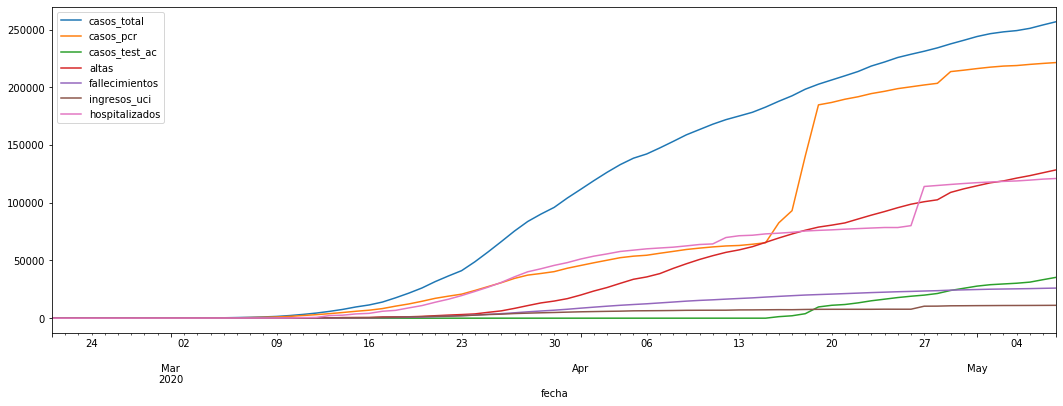

In [5]:
datos.plot()

In [6]:
datos = datos[['casos_total', 'fallecimientos', 'altas']]
datos.columns = ['CONTAGIOS', 'MUERTOS', 'ALTAS']
datos.head()

,CONTAGIOS,MUERTOS,ALTAS
fecha,,,
2020-02-21,2,0,0
2020-02-22,2,0,0
2020-02-23,2,0,0
2020-02-24,2,0,0
2020-02-25,3,0,0


In [7]:
# datos = datos.loc[:'2020-04-08', :]

datos['DIFER_DIAS'] = datos.index.to_series().diff().fillna(pd.Timedelta(seconds = 8660000)).apply(lambda x: x.days)

datos['CONT_DIARIOS'] = (datos['CONTAGIOS'].diff(1).fillna(0)/datos['DIFER_DIAS'])
datos['M_DIARIOS'] = (datos['MUERTOS'].diff(1).fillna(0)/datos['DIFER_DIAS'])
datos['ALTAS_DIARIAS'] = (datos['ALTAS'].diff(1).fillna(0)/datos['DIFER_DIAS'])

index_for_merge = pd.DataFrame(index = pd.date_range(datos.index[0], datos.index[-1]))

# Creamos un dataframe con todas las fechas para ambas series, y rellenamos los NaN con el último dato inmediatamente anterior:

datos_full_index = pd.merge(index_for_merge, datos, left_index= True, right_index= True, how='left')

datos_full_index[['CONT_DIARIOS', 'M_DIARIOS', 'ALTAS_DIARIAS']] = datos_full_index[['CONT_DIARIOS', 'M_DIARIOS', 'ALTAS_DIARIAS']].fillna(method = 'backfill')

datos_full_index['MARCA'] = datos_full_index['CONTAGIOS'].apply(lambda x: 0 if x > 0 else 1)

datos_full_index.loc[datos_full_index['MARCA'] == 1, ['CONT_DIARIOS', 'M_DIARIOS', 'ALTAS_DIARIAS']] = datos_full_index.loc[datos_full_index['MARCA'] == 1, ['CONT_DIARIOS', 'M_DIARIOS', 'ALTAS_DIARIAS']].cumsum()


datos_full_index[['CONTAGIOS','MUERTOS', 'ALTAS']] = datos_full_index[['CONTAGIOS','MUERTOS', 'ALTAS']].fillna(method = 'ffill')
datos_full_index.loc[datos_full_index['MARCA'] == 1, 'CONTAGIOS'] = datos_full_index.loc[datos_full_index['MARCA'] == 1, 'CONTAGIOS'] + datos_full_index.loc[datos_full_index['MARCA'] == 1, 'CONT_DIARIOS']
datos_full_index.loc[datos_full_index['MARCA'] == 1, 'MUERTOS'] = datos_full_index.loc[datos_full_index['MARCA'] == 1, 'MUERTOS'] + datos_full_index.loc[datos_full_index['MARCA'] == 1, 'M_DIARIOS']
datos_full_index.loc[datos_full_index['MARCA'] == 1, 'ALTAS'] = datos_full_index.loc[datos_full_index['MARCA'] == 1, 'ALTAS'] + datos_full_index.loc[datos_full_index['MARCA'] == 1, 'ALTAS_DIARIAS']

datos_full_index['CONTAGIOS'] = datos_full_index['CONTAGIOS'].astype('int')
datos_full_index['MUERTOS'] = datos_full_index['MUERTOS'].astype('int')
datos_full_index['ALTAS'] = datos_full_index['ALTAS'].astype('int')

datos_full_index['R'] = datos_full_index['MUERTOS'] + datos_full_index['ALTAS']
datos_full_index['I'] = datos_full_index['CONTAGIOS'] - datos_full_index['R']

datos_full_index = datos_full_index[['CONTAGIOS', 'MUERTOS', 'ALTAS', 'R', 'I']]

datos_full_index[['C_DIA', 'M_DIA', 'A_DIA', 'R_DIA', 'I_DIA']] = datos_full_index[['CONTAGIOS', 'MUERTOS', 'ALTAS', 'R', 'I']].diff(1).fillna(0).astype(int)

datos_full_index = datos_full_index['2020-03-12':]

Estos serán las series protagonistas de nuestro modelo:

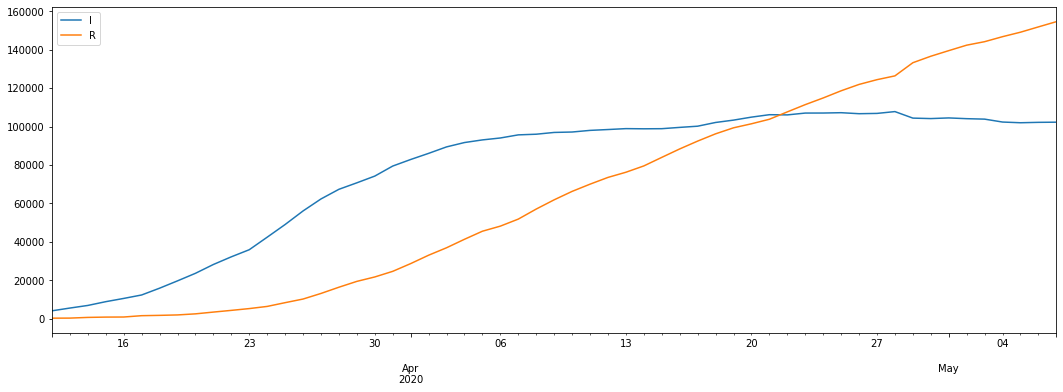

In [8]:
datos_full_index[['I', 'R']].plot();

Y, en concreto, empezaremos modelando la relación:

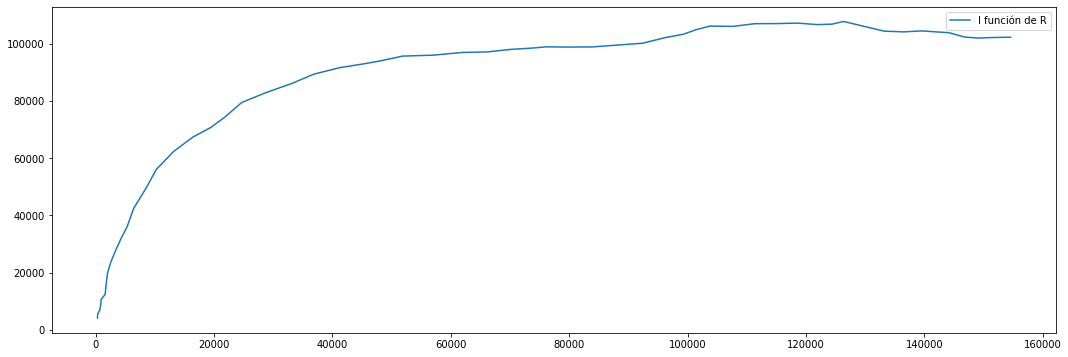

In [9]:
plt.plot(datos_full_index['R'], datos_full_index['I'], label = 'I función de R')
plt.legend();

## 2) Aplicación de ecuaciones del modelo

Definimos primero unas cuantas funciones que emplearemos en el bucle a continuación:

In [10]:
# Función de error para ajuste por mínimos cuadrados de y(z):

def error_y(variab, z, y, weights):
    
    A, N, N1, N3 = variab
    
    y_est = -z - N1 * np.exp(-(z - N3) / A) + N

    aux = list(y_est[y_est < 0])
    
    if y_est[0] > 4000:
        
        return weights * (y - y_est)
    
    else:
        
        return np.ones(len(y_est)) * 99999

In [11]:
# Función de error para ajuste por mínimos cuadrados de y(u):

def error_y_de_u(variab, u, y, weights):
    
    A, N, N1, N3 = variab
    
    y_est = A * np.log(u) - N1 * u * np.exp(N3 / A) + N
    
    aux = list(y_est[y_est < 0])
    
    if y_est[0] > 4000:
        
        return weights * (y - y_est)
    
    else:
        
        return np.ones(len(y_est)) * 99999

In [12]:
# Función auxiliar para integrar por método de Simmpson:

def integral(x):
    
    prov = datos_full_index[datos_full_index['u'] >= x]

    return simps(prov['f'], prov['u']) 

In [13]:
# Función auxiliar para integrar por método de Simmpson en DataFrame de relación u(t):

def integral_reg_u(x):
    
    prov = df_reg_u[df_reg_u['u'] >= x]

    return simps(prov['f'], prov['u']) 

In [14]:
def error_t(variab, inte, t, weights):

    beta = variab

    return weights * (t - 1/beta * inte)

Y, a continuación, comentado, el bucle que hace todo lo descrito en la introducción:

In [15]:
# Algunos parámetros inciales y variables de memoria de resultados:

iteraciones = 10

weights = np.ones(datos_full_index.shape[0])
datos_full_index['DIA'] = list(range(0, datos_full_index.shape[0]))

coefs_m = np.array([0.,0.,0.,0.])
beta_m = 0

# Bucle:

for i in range(iteraciones):
    
    print(i)
    
    # En un primer paso, hace el ajuste de y(z):

    if i == 0:

        vas = [50000, 180000, 80000, 36000]
        bounds = ([0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf])

        sal = least_squares(error_y, vas, args=(datos_full_index['R'], datos_full_index['I'], weights), bounds = bounds)

        # Guardamos algunos valores por separado según respondan al ajuste por y(z) o y(u):
        
        coefs_i_1 = sal.x

        z = datos_full_index['R']

        A, N, N1, N3 = coefs_i_1
        y_est_1 = -z - N1 * np.exp(-(z - N3) / A) + N
        
        print(coefs_i_1.round())
        print (y_est_1.max(), y_est_1[-1])
        
    # En el resto, hace el ajuste de y(u):

    else:

        vas = coefs_i_1
        bounds = ([0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf])

        x = np.array(nuevos_puntos)
        y = np.array(datos_full_index['I'])

        sal = least_squares(error_y_de_u, vas, args=(x, y, weights), bounds = bounds)
        
        # Guardamos algunos valores por separado según respondan al ajuste por y(z) o y(u):

        coefs_i_2 = sal.x

        A, N, N1, N3 = coefs_i_2

        y_est_2 = A * np.log(x) - N1 * x * np.exp(N3 / A) + N
        
        print(coefs_i_2.round())
        print (y_est_2.max(), y_est_2[-1])
        
        coefs_m += coefs_i_2

    # Guardamos otros resultados de la optimización:
        
    coste = sal.cost
    res = sal.fun
    opt = sal.optimality
    
    # Imprimimos valores para comprobar los resultados de la misma:

    print(res.mean(), abs(res).mean())

    # Calculamos ya algunos parámetros del modelo (tal vez lo borre en un futuro):
    
    N2 = N - N1 - N3
    u0 = np.exp(-N3/A)
    x0 = N1/ u0
    N20 = N - x0
    u_lim = A/x0
    z_lim = -A * np.log(u_lim)
    y_lim = -z_lim - N1 * np.exp(-(z_lim - N3) / A) + N
    
    # Imprimimos el valor de y_lim para compararlo con el del máximo y el último de nuestro ajuste:
    
    print(y_lim)
    
    # Guardamos los valores de las distintas estimaciones realizadas. También calculamos u en función del caso en el que
    # nos encontramos:
    
    if i == 0:

        datos_full_index['I_EST_' + str(i+1)] = y_est_1
        datos_full_index['u'] = np.exp(-datos_full_index['R']/A)
        
    else:
        
        datos_full_index['I_EST_' + str(i+1)] = y_est_2
        datos_full_index['u'] = np.array(nuevos_puntos)  
        
    # Calculamos la función para integrar y la integramos, empleando la función auxiliar definida más arriba:
    
    datos_full_index['f'] = 1/(datos_full_index['u'] * ( -N -A * np.log(datos_full_index['u']) + N1/u0 * datos_full_index['u']))
    
#     datos_full_index['f'] = - 1/(datos_full_index['u'] * datos_full_index['I_EST_' + str(i+1)])
    datos_full_index['int'] = datos_full_index['u'].apply(integral)
    
    # Damos valores iniciales y realizamos el segundo ajuste:
    if i == 0:
        vas_2 = [0.0003]
    else:
        vas_2 = beta
        
    bounds_2 = (0, 1)

    sal_2 = least_squares(error_t, vas_2, args=(datos_full_index['int'], datos_full_index['DIA'], weights), bounds = bounds_2)

    # Obtenemos beta, que guardamos, imprimimos y metemos en una variable que medirá valores medios:
    
    beta = sal_2.x[0]
    print(beta)
    
    # Guardamos por separado la beta del primer método:
    
    if i == 0:
        
        beta0 = beta
        
    else:
        
        beta_m += beta
    
    # Reajustamos f y la integral con los betas obtenidos:

#     datos_full_index['f'] = 1/beta * datos_full_index['f']
#     datos_full_index['int'] = 1/beta * datos_full_index['int']
    
#     beta = beta *( 0.9 * datos_full_index['int'][-1]/datos_full_index['DIA'][-1])
    
    # Creamos ahora un dataframe auxiliar con un u de paso fino, para obtener u(t):
    
    # Creamos el array de u y lo guardamos en un DataFrame:

    u_range = np.arange(datos_full_index['u'].max(), 0.0, - datos_full_index['u'].diff(1).abs().min()/10, dtype = np.float64)
    
    
#     aux = np.linspace(8, -8, 1000)
#     u_range = 1/(np.exp(-aux) + 1)
#     u_range = u_range[u_range <= datos_full_index['u'].max()]
#     u_range[0] = datos_full_index['u'].max()
    
    df_reg_u = pd.DataFrame(u_range, columns = ['u'], dtype = np.float64)
    
    # Calculamos con nuestros parámetros f y la integral:
    df_reg_u['y'] = A * np.log(df_reg_u['u']) - N1 * df_reg_u['u'] * np.exp(N3 / A) + N
    df_reg_u['z'] = - A * np.log(df_reg_u['u'])
    df_reg_u['tot_infectados'] = df_reg_u['y'] + df_reg_u['z']
    df_reg_u['f'] = 1/beta * (1/(df_reg_u['u'] * ( -N -A * np.log(df_reg_u['u']) + N1/u0 * df_reg_u['u'])))
#     df_reg_u['f'] = - 1/beta * (1/(df_reg_u['u'] * df_reg_u['y']))
    df_reg_u['int'] = df_reg_u['u'].apply(integral_reg_u)
    
    df_reg_u = df_reg_u[df_reg_u['y'] >= 0]
    
    # Nos quedamos con la parte entera de la integral, el mínimo para cada una será el valor que más se ajusta al propio entero.
    
    # Por ejemplo, habrá varios valores de la integral: 1.083, 1.223, 1.579, 1.892... el que más se parece al 1 
    # será el primero de ellos. Hacemos eso para todos los valores del rango de nuestras fechas, y filtramos para quedarnos sólo
    # estos valores:
    
    df_reg_u['marca'] = df_reg_u['int'].astype(int)

    filtro = df_reg_u[df_reg_u['marca'] <= datos_full_index['DIA'].max()].groupby('marca')['int'].min()
    
    # Tenemos finalmente entonces estos valores, que entrarán en la segunda iteración del bucle y siguientes, para calcular
    # el ajuste ahora de y(u):

    nuevos_puntos = df_reg_u[df_reg_u['int'].isin(filtro)][['u', 'marca']].set_index('marca')['u']
    
    # Si u no permite la creación de un rango de valores apropiado, lo advertimos y salimos:
    
    if i < iteraciones - 1 and nuevos_puntos.index.max() != datos_full_index['DIA'].max():
        
        print ('\niteración', i, ':' , 'problema en el rango de u')
        
        break
                                                                         
    elif i < iteraciones -1  and len(nuevos_puntos.index) !=  len(datos_full_index['DIA']):

        print ('\niteración', i, ':' , 'los arrays no tienen las mismas dimesiones')
        
        break    
    
    print('\n')
    
coefs_m = coefs_m/i
beta_m = beta_m/i

0
[ 78208. 284293. 127628.  57255.]
110525.57313740073 92942.92651761885
-0.03499558084366614 7114.969826493561
110528.30675487255
4.521822213637066e-07


1
[ 78450. 290031. 222526.  18293.]
111479.06554481713 93319.10812138871
-0.06422243192597914 5955.559907610367
111497.19254098501
5.300463028602425e-07


2
[ 72709. 279590. 122848.  55108.]
113622.76625402409 91206.25070188209
-3.468134213778141e-05 8287.893249162542
113638.5349557572
4.592821146851012e-07


3
[ 75419. 284776.  86172.  87359.]
111921.17643352639 92710.94018091104
-0.1024041709034671 6364.170146229149
111945.51400308148
5.198563126702139e-07


4
[ 72064. 278536. 122422.  54964.]
113303.42992013111 91522.78121620856
-0.008816443357653426 7904.212704019736
113319.87553282978
4.716969582482773e-07


5
[ 73853. 281933. 147095.  45027.]
112143.76089353926 92503.02063590346
-0.12449941396143434 6605.459446497119
112167.79199106875
5.126554037583682e-07


6
[ 71641. 277807. 122141.  54855.]
113071.56213509408 91697.64612213

Comprobamos ahora la bondad de nuestro ajuste para ver que efectivamente los resultados son buenos:

In [16]:
for columna in datos_full_index.columns:
    
    if columna.startswith('I_EST'):

        print ("R2 de", columna, ":", r2_score(datos_full_index['I'], datos_full_index[columna]))

R2 de I_EST_1 : 0.9415464296544512
R2 de I_EST_2 : 0.9607609660880975
R2 de I_EST_3 : 0.9230474545522378
R2 de I_EST_4 : 0.9553943354822093
R2 de I_EST_5 : 0.9304046295333861
R2 de I_EST_6 : 0.9519543173565971
R2 de I_EST_7 : 0.9352050881457599
R2 de I_EST_8 : 0.9495985103282633
R2 de I_EST_9 : 0.9381793082427866
R2 de I_EST_10 : 0.9477640123227389


## 3) Visualización de resultados y comparación de parámetros

### 3.1) Visualizaciones

Como podemos ver a continuación, como resultado de las iteraciones anteriores hemos podido alisar la forma de la curva, un tanto basta, que nos aparecía al principio, así como hemos podido hacer converger los valores de los parámetros del modelo:

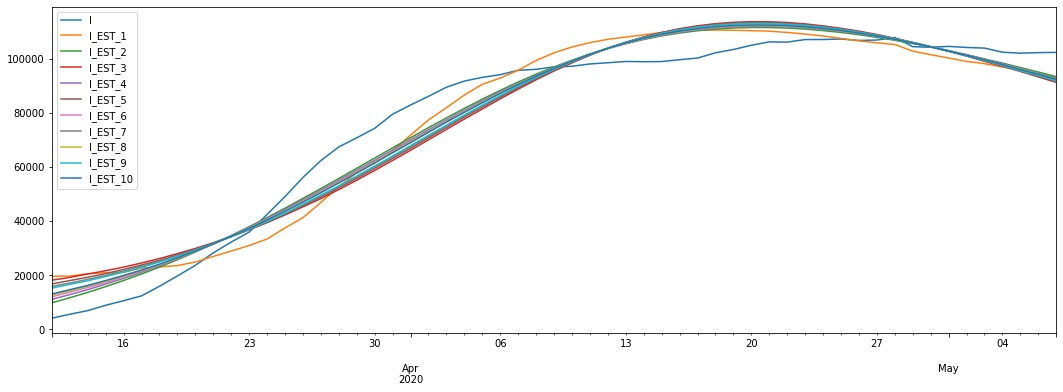

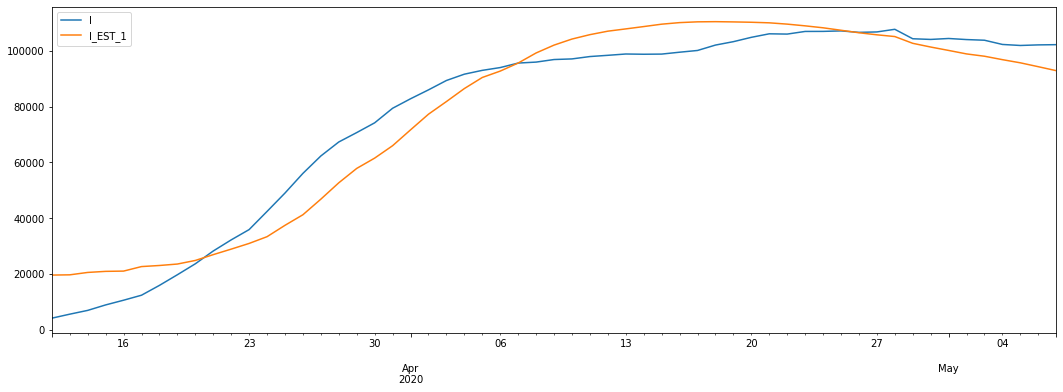

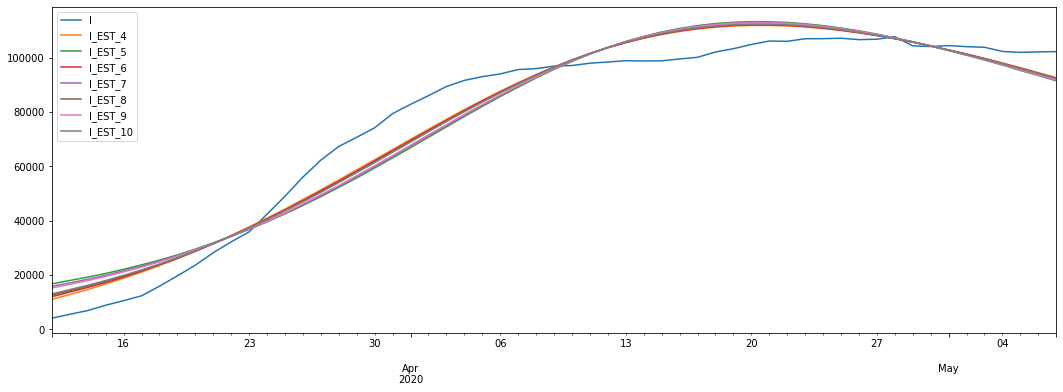

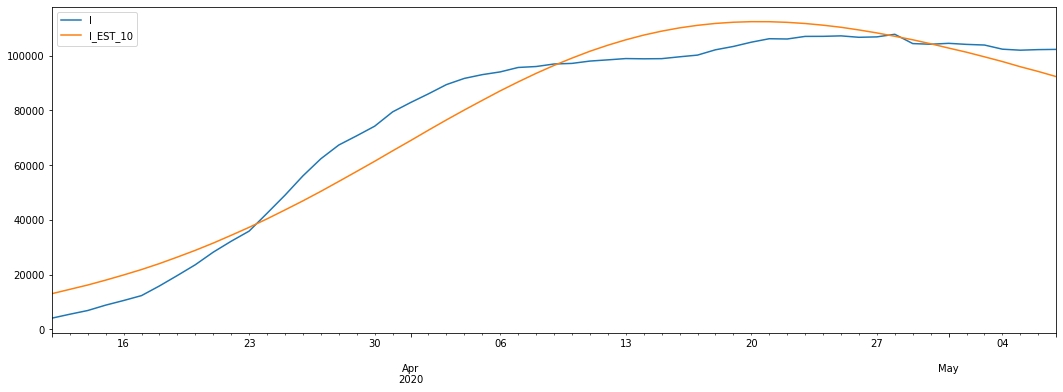

In [17]:
lista = list('I')

for element in datos_full_index.columns:
    
    if element.startswith('I_EST'):
        
        lista.append(element)
        
datos_full_index[lista].plot()

datos_full_index[lista[:2]].plot()
        
datos_full_index[['I'] + lista[4:]].plot()

datos_full_index[['I', 'I_EST_10']].plot()

Para los contagiados totales tendremos:

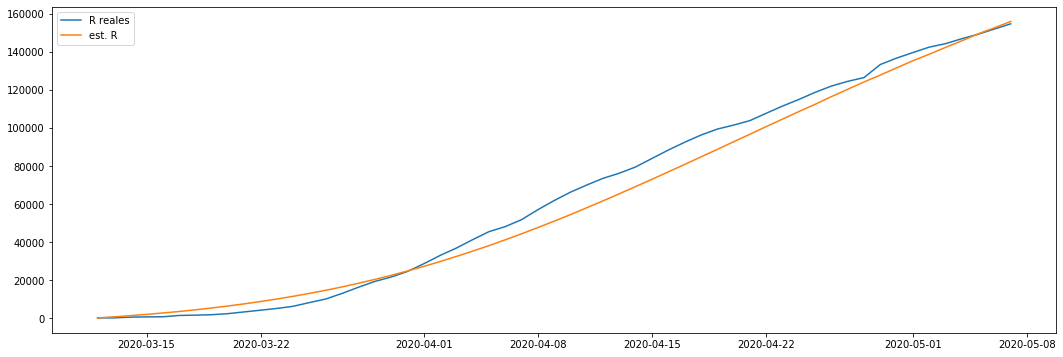

In [18]:
datos_full_index['R_EST'] = -A * np.log(datos_full_index['u'])
datos_full_index['CONTAGIOS_EST'] = datos_full_index['I_EST_10'] + datos_full_index['R_EST']

plt.plot(datos_full_index.index, datos_full_index['R'], label = 'R reales')
plt.plot(datos_full_index.index, datos_full_index['R_EST'], label = 'est. R')
plt.legend();

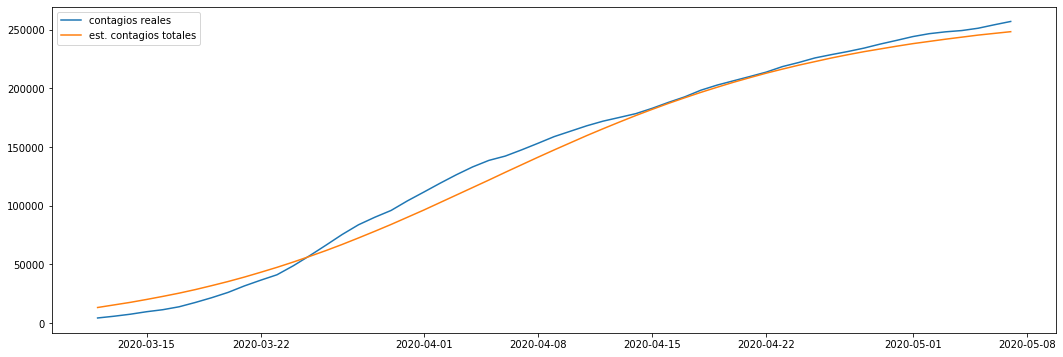

In [19]:
plt.plot(datos_full_index.index, datos_full_index['CONTAGIOS'], label = 'contagios reales')
plt.plot(datos_full_index.index, datos_full_index['CONTAGIOS_EST'], label = 'est. contagios totales')
plt.legend();

Respecto a la relación I(R) con la que hemos comenzado nuestras iteraciones, tendremos ahora:

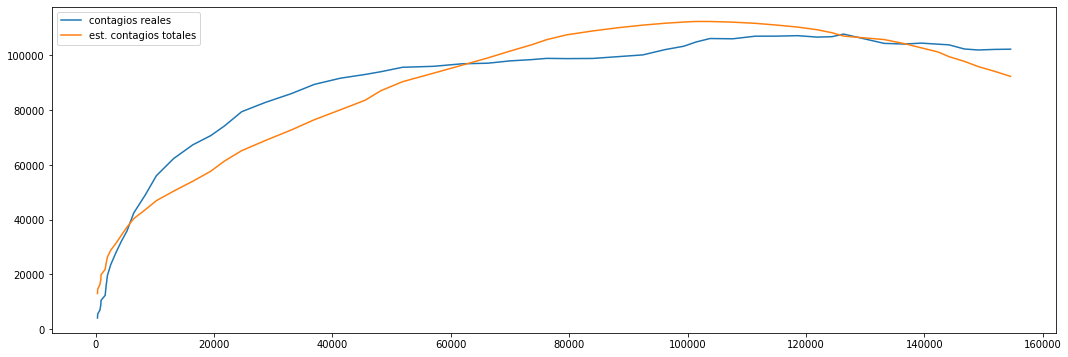

In [20]:
plt.plot(datos_full_index['R'], datos_full_index['I'], label = 'contagios reales')
plt.plot(datos_full_index['R'], datos_full_index['I_EST_10'], label = 'est. contagios totales')
plt.legend();

### 3.2) Comparación de parámetros

Vamos ahora a comparar los valores de los resultados empleando el ajuste y(u), comparando los valores medios almacenados con los de la última realización:

In [21]:
A_m, N_m, N1_m, N3_m = coefs_m
A_0, N_0, N1_0, N3_0 = coefs_i_1

gamma = A * beta
gamma_m = A_m * beta_m

In [22]:
print(coefs_i_1.round())
print(coefs_i_2.round())
print(coefs_m.round())

[ 78208. 284293. 127628.  57255.]
[ 72241. 279001.  90120.  78368.]
[ 73393. 281002. 135854.  52757.]


In [23]:
print(beta0)
print(beta)
print(beta_m)

4.521822213637066e-07
5.05532451241668e-07
4.971428770239277e-07


In [24]:
print(beta0 * N_0)
print(beta * N)
print(beta_m * N_m)

0.12855230792212682
0.14104425903964868
0.13969815474587777


In [25]:
N2 = N - N1 - N3
print(N2.round())
print(N3.round())
print(u0)

110513.0
78368.0
0.33796202284341054


In [26]:
datos_full_index.loc['2020-03-31',['I', 'R', 'u']]

I   79,448.0000
R   24,659.0000
u        0.7082
Name: 2020-03-31 00:00:00, dtype: float64

In [27]:
print('gamma:', gamma, '\ngamma_med:', gamma_m)
print('beta:', beta * N, '\nbeta_med:', beta_m * N_m)
print('factor de crecimiento:', np.exp(beta * N), '\nfactor de crecimiento_med:', np.exp(beta_m * N_m))

gamma: 0.036520110793755806 
gamma_med: 0.0364869222754221
beta: 0.14104425903964868 
beta_med: 0.13969815474587777
factor de crecimiento: 1.1514756100616497 
factor de crecimiento_med: 1.1499266465658726


In [28]:
print('valores en punto u0:\n')
print('u0:', u0.round(4))
print('N1:', N1.round())
print('N2:', N2.round())
print('N3:', N3.round())

valores en punto u0:

u0: 0.338
N1: 90120.0
N2: 110513.0
N3: 78368.0


In [29]:
datos_full_index.loc['2020-04-02', ['u', 'I', 'R']]

u        0.6613
I   86,048.0000
R   33,048.0000
Name: 2020-04-02 00:00:00, dtype: float64

In [30]:
u_t_0 = datos_full_index.loc[datos_full_index.index[0], 'u']

print('valores iniciales:')
print('x0:', x0)
print('N20:', N20)
print('N30:', -A * np.log(u_t_0))

valores iniciales:
x0: 266658.1523363195
N20: 12343.24251621979
N30: 265.10364664792155


In [31]:
datos_full_index.loc[datos_full_index.index[0], ['u', 'I', 'R']]

u       0.9963
I   4,117.0000
R     287.0000
Name: 2020-03-12 00:00:00, dtype: float64

In [32]:
print('valores en punto de inflexión:\n')
print('u lim:', u_lim)
print('y lim:', y_lim)
print('z lim:', z_lim)
print('contagios:', y_lim + z_lim)

valores en punto de inflexión:

u lim: 0.27091196209830626
y lim: 112416.70843466098
z lim: 94343.80315893693
contagios: 206760.5115935979


In [33]:
datos_full_index.loc['2020-04-08', ['u', 'I', 'R']]

u        0.5167
I   96,015.0000
R   57,067.0000
Name: 2020-04-08 00:00:00, dtype: float64

## 4) Predicciones

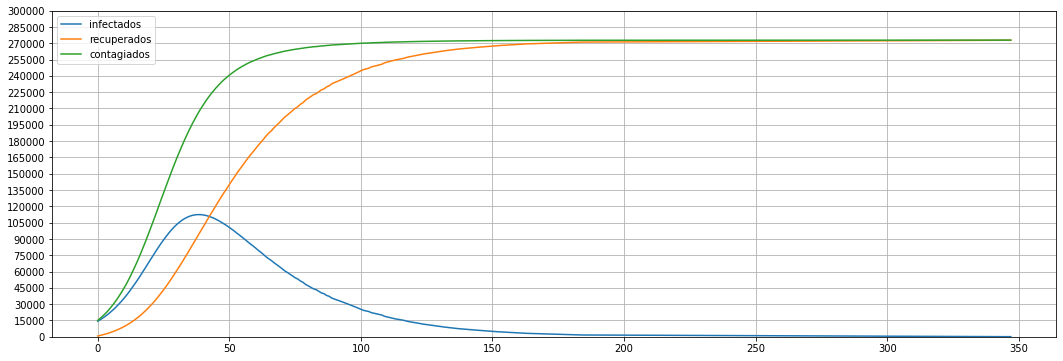

In [34]:
df_reg_u_red = df_reg_u[df_reg_u['int'].isin(df_reg_u.groupby(['marca'])['int'].max())]

plt.plot(df_reg_u_red['marca'], df_reg_u_red['y'], label = 'infectados')
plt.plot(df_reg_u_red['marca'], df_reg_u_red['z'], label = 'recuperados')
plt.plot(df_reg_u_red['marca'], df_reg_u_red['z'] + df_reg_u_red['y'], label = 'contagiados')
plt.ylim([0,200000])
plt.yticks(np.linspace(0,300000,21))
plt.grid(True)
plt.legend();

**Punto de inflexión en curva de infectados (ingresados):**

In [35]:
df_reg_u_red[df_reg_u_red['y'].pct_change()<0].head(1)

,u,y,z,tot_infectados,f,int,marca
1346,0.2619,"112,375.8751","96,786.4136","209,162.2888",-67.2100,39.9861,39


In [36]:
t0 =pd.to_datetime('2020-03-12') 
t0 + datetime.timedelta(days = 39)

Timestamp('2020-04-20 00:00:00')

In [37]:
datos_full_index[['CONTAGIOS', 'R', 'I']].tail()

,CONTAGIOS,R,I
2020-05-03,248028,144166,103862
2020-05-04,249120,146771,102349
2020-05-05,251081,149099,101982
2020-05-06,254050,151859,102191
2020-05-07,256855,154581,102274


**Segundo punto de inflexión:**
    
Incrementos en el total de infectados menores al 1%:

In [38]:
df_reg_u_red[df_reg_u_red['tot_infectados'].pct_change()<0.01].head(1)

,u,y,z,tot_infectados,f,int,marca
1534,0.1593,"103,823.2978","132,692.8903","236,516.1881",-119.5841,48.9924,48


In [39]:
pd.to_datetime('2020-03-12') + datetime.timedelta(days = 48)

Timestamp('2020-04-29 00:00:00')

**Fechas fin orientativas:**

In [40]:
df_reg_u_red.tail(20)

,u,y,z,tot_infectados,f,int,marca
1765,0.0333,"24,309.0227","245,817.5418","270,126.5645","-2,444.9966",101.9273,101
1766,0.0327,"23,260.3444","247,011.7196","270,272.0639","-2,597.8180",103.3020,103
1767,0.0322,"22,191.5934","248,225.9700","270,417.5634","-2,769.0842",104.7658,104
1768,0.0316,"21,102.0835","249,460.9794","270,563.0629","-2,962.2648",106.3278,106
1769,0.0311,"19,991.0924","250,717.4699","270,708.5623","-3,181.7526",108.0034,108
1770,0.0306,"18,857.8597","251,996.2021","270,854.0618","-3,433.1909",109.8058,109
1771,0.0300,"17,701.5838","253,297.9775","270,999.5613","-3,723.9530",111.7575,111
1772,0.0295,"16,521.4187","254,623.6420","271,145.0607","-4,063.8582",113.8787,113
1773,0.0289,"15,316.4715","255,974.0887","271,290.5602","-4,466.2776",116.2043,116
1774,0.0284,"14,085.7978","257,350.2619","271,436.0597","-4,949.8975",118.7674,118


In [41]:
pd.to_datetime('2020-03-12') + datetime.timedelta(days = 108)

Timestamp('2020-06-28 00:00:00')

In [42]:
pd.to_datetime('2020-03-12') + datetime.timedelta(days = 130)

Timestamp('2020-07-20 00:00:00')